In [1]:
from stop_metrics import create_combined_metrics_stop_df, time_to_next_stop
from trip_metrics import create_combined_metrics_trip_df
from utils import create_trips_df, create_trips_df_pid
from create_metrics import create_metrics
import matplotlib.pyplot as plt
import random
import plotly.express as px
import polars as pl
import pandas as pd


In [ ]:
def weighted_metric_grouping(df, period, metric, count, grouping):
    df = df.filter(pl.col('period') == period)
    df = df.with_columns(pl.col(count).sum().over(['period_value',grouping]).alias('trip_count'))
    df = df.with_columns((pl.col(count) / pl.col('trip_count')).alias('time_till_weight'))

    df_filtered = df.select(['rt','pid','period_value','community','time_till_weight', metric])
    df_filtered = df_filtered.filter(pl.col('time_till_weight').is_not_nan())

    df_filtered = df_filtered.sort(metric)

    # Calculate the cumulative sum of 'indweight'
    df_filtered = df_filtered.with_columns(pl.col("time_till_weight").cum_sum().over(['period_value',grouping]).alias("cum_sum"))


    #Find the median then take first value
    median = df_filtered.filter(pl.col("cum_sum")>= 0.5)
    final = median.group_by(['period_value',grouping], maintain_order=True).first().filter(pl.col("period_value")!= '2022-05-01').sort("period_value")
    final = final.with_columns((pl.col(metric).dt.total_seconds() / 60).alias("median_minutes"))

    return final.select(['period_value',grouping,'median_minutes'])

In [2]:
def average_by(df:pd.DataFrame, grouping:str, period:str, metrics:list):
    """
    grouping helper function 
    # TODO weighted mean here, maybe switch to polars
    """
    if 'community' in df.columns:
        df = df[['rt','period','period_value', 'community']+metrics]
    else: 
        df = df[['rt','period','period_value']+metrics]
        
    if period == "one_value":
        by_period = df[df['period'] == 'dayofyear']
        by_period_grouped = by_period.groupby([grouping])[metrics].median().reset_index()

    elif period == 2024:
        # only 2024 data
        by_period = df[(df['period'] == 'year') & (df['period_value'] == '2024')] 
        by_period_grouped = by_period.groupby([grouping])[metrics].median().reset_index()

    elif period in df['period'].unique():
        by_period = df[df['period']== period]
        # df.groupby(df.index).apply(lambda x: np.average(x.wt, weights=x.value))

        by_period_grouped = by_period.groupby([grouping,'period_value'])[metrics].median().reset_index()
    else:
        print("Invalid period")
        
    #convert to minutes
    for metric in metrics:
        if 'num_buses' not in metric:
            by_period_grouped[metric] = by_period_grouped[metric].dt.total_seconds()/60

    
    return by_period_grouped

In [3]:
def load_metrics():
    """
    Load metrics, combine them, add in community stop crosswalk, and remove weird routes
    """
    #loading data
    ca_xwalk = pl.read_parquet('communities_stops.parquet')
    ca_xwalk = ca_xwalk.select(['community','stpid']).rename({'stpid':'stop_id'})

    total_stops = pl.read_parquet('out/stops_metrics_all_periods.parquet')
    total_trips = pl.read_parquet('out/trips_metrics_all_periods.parquet')

    # take out weird routes
    total_trips = total_trips.filter(~pl.col('rt').is_in(['5','169']))
    total_stops = total_stops.filter(~pl.col('rt').is_in(['5','169']))

    return total_stops, total_trips

In [4]:
def create_summary_metrics(df_stops, df_trips, grouping:str, period:str):
    """
    Load the metrics, average them by a grouping (route:'rt' or community 
    area: 'community_area) and period ('hour','weekday','dayofyear','week',
    'month','year', 'one_value': median of all day metrics, '2024': filter 
    to year and 2024), and return the dataframe
    """


    # total_stops, total_trips = load_metrics()
    
    metrics_stop = ['median_actual_time_till_next_bus','std_actual_time_till_next_bus','time_till_next_bus_delay','median_schedule_time_till_next_bus', 'std_schedule_time_till_next_bus',
                'median_schedule_num_buses', 'median_actual_num_buses']
    
    metrics_trip = ['median_actual_trip_duration', 'median_schedule_trip_duration']
    
    if grouping == 'rt':
        avg_stops = average_by(df_stops.to_pandas(),grouping, period, metrics_stop)
        metrics_trip = ['median_actual_trip_duration', 'median_schedule_trip_duration']
        avg_trips = average_by(df_trips.to_pandas(),grouping, period, metrics_trip)
        avg_trips['trip_delay'] = avg_trips['median_actual_trip_duration'] - avg_trips['median_schedule_trip_duration']
        avg_stops['bus_excess'] = avg_stops['median_actual_num_buses'] - avg_stops['median_schedule_num_buses']
        if period in ['one_value',2024]:
            all_metrics_rts = avg_stops.join(avg_trips.set_index(grouping), on=grouping)
        else:   
            all_metrics_rts = avg_stops.join(avg_trips.set_index([grouping,'period_value']), on=[grouping,'period_value'])
        return all_metrics_rts
    
    elif grouping == 'community_area':
        all_metrics_ca = average_by(df_stops.to_pandas(),'community', period, metrics_stop)
        all_metrics_ca['bus_excess'] = all_metrics_ca['median_actual_num_buses'] - all_metrics_ca['median_schedule_num_buses']

        return all_metrics_ca

    


In [4]:
total_stops, total_trips = load_metrics()

In [8]:
all_metrics_rt_2024 = create_summary_metrics(total_stops, total_trips, 'rt', 2024)


      rt  median_actual_time_till_next_bus  std_actual_time_till_next_bus  \
0      1                         15.670872                     334.818991   
1    100                         20.153942                     355.481222   
2    103                         17.769398                       8.834920   
3    106                         15.597478                      75.837921   
4    108                         17.004015                       7.172553   
..   ...                               ...                            ...   
115   96                         19.982009                      12.998692   
116   97                         19.885183                      84.921098   
117  J14                         13.234371                      22.839885   
118  X49                         10.022932                     284.825046   
119   X9                         11.793912                      42.491587   

     time_till_next_bus_delay  median_schedule_time_till_next_bus  \
0     

In [ ]:
#create some tables for the exploration 

# all_metrics_rt_month = create_summary_metrics(total_stops, total_trips, 'rt', 'month')
# all_metrics_rt_hour = create_summary_metrics(total_stops, total_trips, 'rt', 'hour')
# all_metrics_rt_weekday = create_summary_metrics(total_stops, total_trips,'rt', 'weekday')
# all_metrics_rt_year = create_summary_metrics(total_stops, total_trips,'rt', 'year')
all_metrics_rt_week_abs = create_summary_metrics(total_stops_add, total_trips_add, 'rt', 'week_abs')
all_metrics_rt_month_abs = create_summary_metrics(total_stops_add, total_trips_add,'rt', 'month_abs')

combined = pd.concat([all_metrics_rt_month, all_metrics_rt_hour, all_metrics_rt_weekday, all_metrics_rt_year, all_metrics_rt_week_abs,all_metrics_rt_month_abs])


In [18]:
combined

,rt,period_value,median_actual_time_till_next_bus,std_actual_time_till_next_bus,time_till_next_bus_delay,median_schedule_time_till_next_bus,std_schedule_time_till_next_bus,median_schedule_num_buses,median_actual_num_buses,bus_excess,median_actual_trip_duration,median_schedule_trip_duration,trip_delay
0,1,1,15.537642,320.383892,-0.069920,15.500000,517.999404,494.0,508.5,14.5,36.726002,31.0,5.726002
1,1,2,15.461163,323.573718,-0.221402,15.483333,324.303945,425.0,495.5,70.5,36.788603,32.5,4.288603
2,1,3,15.438998,347.651206,-0.071545,15.483333,327.951535,525.0,521.5,-3.5,36.901218,34.0,2.901218
3,1,4,15.670397,329.068820,0.273250,15.483333,324.525114,525.0,481.5,-43.5,37.182187,32.0,5.182187
4,1,5,15.967163,361.950871,0.581611,15.483333,5231.402394,525.0,486.5,-38.5,37.666500,32.5,5.166500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,X9,2024-01-01 00:00:00,13.028521,42.781422,1.518146,11.000000,42.510396,297.0,278.0,-19.0,88.054202,83.0,5.054202
3275,X9,2024-02-01 00:00:00,12.529681,42.900167,1.139929,11.000000,42.501516,283.5,270.5,-13.0,90.405004,83.0,7.405004
3276,X9,2024-03-01 00:00:00,12.139489,41.840264,0.761862,11.000000,41.813344,271.0,260.0,-11.0,88.159518,84.5,3.659518
3277,X9,2024-04-01 00:00:00,10.935800,41.461688,-0.064200,11.000000,39.989162,286.0,278.0,-8.0,89.702337,87.5,2.202337


In [19]:
all_metrics_rt_month['period'] = 'month'
all_metrics_rt_hour['period'] = 'hour'
all_metrics_rt_weekday['period'] = 'weekday'
all_metrics_rt_year['period'] = 'year'
all_metrics_rt_week_abs['period'] = 'week_abs'
all_metrics_rt_month_abs['period'] = 'month_abs'
combined = pd.concat([all_metrics_rt_month, all_metrics_rt_hour, all_metrics_rt_weekday, all_metrics_rt_year, all_metrics_rt_week_abs, all_metrics_rt_month_abs])

In [36]:
rts_fix.to_csv('out/combined_rt.csv', index=False)

In [ ]:
all_metrics_ca_month = create_summary_metrics(total_stops, total_trips, 'community_area', 'month')
all_metrics_ca_hour = create_summary_metrics(total_stops, total_trips, 'community_area', 'hour')
all_metrics_ca_weekday = create_summary_metrics(total_stops, total_trips, 'community_area', 'weekday')
all_metrics_ca_year = create_summary_metrics(total_stops, total_trips, 'community_area', 'year')

all_metrics_ca_month['period'] = 'month'
all_metrics_ca_hour['period'] = 'hour'
all_metrics_ca_weekday['period'] = 'weekday'
all_metrics_ca_year['period'] = 'year'

# combined_ca = pd.concat([all_metrics_ca_month, all_metrics_ca_hour, all_metrics_ca_weekday, all_metrics_ca_year])
# combined_ca.to_csv('out/combined_ca.csv')

In [30]:
all_metrics_ca_week_abs = create_summary_metrics(total_stops_add, total_trips_add, 'community_area', 'week_abs')
all_metrics_ca_month_abs = create_summary_metrics(total_stops_add, total_trips_add, 'community_area', 'month_abs')

all_metrics_ca_week_abs['period'] = 'week_abs'
all_metrics_ca_month_abs['period'] = 'month_abs'

combined_ca = pd.concat([all_metrics_ca_month, all_metrics_ca_hour, all_metrics_ca_weekday, all_metrics_ca_year, all_metrics_ca_week_abs, all_metrics_ca_month_abs])
combined_ca.to_csv('out/combined_ca.csv')

In [32]:
all_metrics_ca_2024 = create_summary_metrics('community_area', 2024)
all_metrics_ca_2024.to_csv('out/all_metrics_ca_2024.csv')

In [10]:
def plot_metrics(df:pd.DataFrame, metric:str, grouping:str, time_period:str = None):
    """
    Plots the metrics for the given dataframe
    """
    df = df[[grouping,metric]]
    if not time_period:
        df = df.sort_values(metric, ascending=False)
        fig = px.bar(df, x=grouping, y=metric)
        fig.show()
    else:
        print("Invalid grouping")

    return True

In [12]:
plot_metrics(all_metrics_rt, 'median_actual_time_till_next_bus', 'rt')


True

In [6]:
total_stops, total_trips = load_metrics()

In [42]:
def create_trip_chart(rt):

    #sample of 100 bus trips
    trips = create_trips_df(rt,is_schedule=False)
    pid = trips.group_by('pid').n_unique().sort('trip_id', descending = True).limit(1).rows(named=True)[0]['pid']
    sample_trips = trips.filter(pl.col('pid') == pid).unique(subset=["trip_id"]).sample(100).select(['trip_id'])

    #sample of 100 trips
    trips_100 = trips.filter(pl.col('trip_id').is_in(sample_trips))
    trips_100 = time_to_next_stop(trips_100)
    trips_100 = trips_100.sort(['trip_id','cum_trip_time'], descending=False)


    # get agg values
    agg = total_stops.select(['rt','pid','period','period_value','stop_id', 'median_actual_cum_trip_time','median_schedule_cum_trip_time'])
    agg = agg.filter((pl.col('rt') == rt) & (pl.col('period') == 'year') & (pl.col('period_value') == 2024) & (pl.col('pid') == pid))
    agg = agg.sort('median_actual_cum_trip_time', descending=False)
    # create a fake stop sequence
    agg = agg.with_row_index()

    #chart

    fig, ax = plt.subplots()
    plt.figure(figsize=(10,10))



    for row in trips_100.iter_rows(named=True):
        subset = trips_100.filter(pl.col('trip_id') == row['trip_id'])
        ax.plot(subset['stop_sequence'], subset.select(pl.col('cum_trip_time')).get_columns()[0].dt.total_seconds()/60, color = 'grey', alpha=0.01, linestyle='dashed')

    ax.plot(agg['index'], agg.select(pl.col('median_schedule_cum_trip_time')).get_columns()[0].dt.total_seconds()/60, label = 'Schedule', linewidth=4)
    ax.plot(agg['index'], agg.select(pl.col('median_actual_cum_trip_time')).get_columns()[0].dt.total_seconds()/60, label = 'Real', linewidth=4)

    ax.legend()
    ax.set_xlabel('Stop Sequence')
    ax.set_ylabel('Trip Duration (minutes)')
    plt.show()


{'pid': 2721}
{'pid': 2725}
{'pid': 7749}
{'pid': 7750}
{'pid': 16548}
{'pid': 16549}


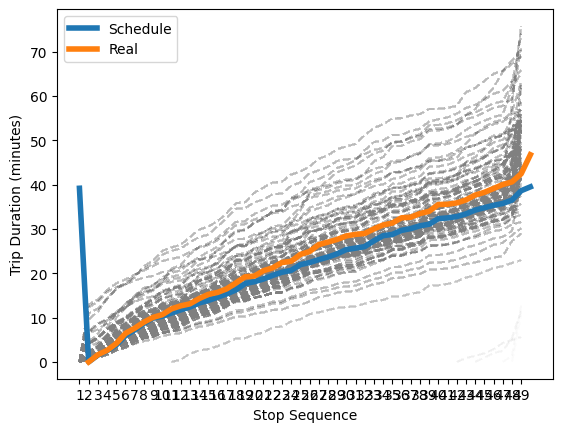

<Figure size 1000x1000 with 0 Axes>

In [54]:
create_trip_chart('92')